### Crate Tensorflow Estimator Class and Train it locally

In [4]:
PROJECT_ID = 'jchavezar-demo'
NUM_NEURONS = 32
L_RATE = 0.001
EPOCHS = 10
TRAIN_START_DATE = "20160801"
TRAIN_END_DATE = "20170430"

In [5]:
from src import Estimator

VertexTF = Estimator.VertexTF(
    project_id=PROJECT_ID,
    epochs=10
)
train, val, test = VertexTF.query(start_date=TRAIN_START_DATE, end_date=TRAIN_END_DATE)

In [6]:
## Prepare data by splitting, shuffling, transform to tensors, normalize and encode categorical values.

train_ds, val_ds, test_ds = VertexTF.preprocessing(target_column='will_buy_on_return_visit')

/home/jesusarguelles/code/vertex-gpu/pipe_notebook/src/data/Transform.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [7]:
model = VertexTF.create_model(nn_input=NUM_NEURONS, lr=L_RATE)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 medium (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 channelGrouping (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 deviceCategory (InputLayer)    [(None, 1)]          0           []                               
                                                                                              

In [9]:
model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/10


/home/jesusarguelles/miniconda3/envs/gcp/lib/python3.7/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['will_buy_on_return_visit'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14325/14325 [==============================] - 28s 2ms/step - loss: 0.0586 - accuracy: 0.9846 - val_loss: 0.0515 - val_accuracy: 0.9846
Epoch 2/10
14325/14325 [==============================] - 28s 2ms/step - loss: 0.0533 - accuracy: 0.9847 - val_loss: 0.0516 - val_accuracy: 0.9846
Epoch 3/10
14325/14325 [==============================] - 29s 2ms/step - loss: 0.0532 - accuracy: 0.9847 - val_loss: 0.0516 - val_accuracy: 0.9846
Epoch 4/10
14325/14325 [==============================] - 30s 2ms/step - loss: 0.0531 - accuracy: 0.9847 - val_loss: 0.0515 - val_accuracy: 0.9846
Epoch 5/10
14325/14325 [==============================] - 40s 3ms/step - loss: 0.0531 - accuracy: 0.9847 - val_loss: 0.0517 - val_accuracy: 0.9846
Epoch 6/10
14325/14325 [==============================] - 29s 2ms/step - loss: 0.0531 - accuracy: 0.9847 - val_loss: 0.0515 - val_accuracy: 0.9846
Epoch 7/10
14325/14325 [==============================] - 28s 2ms/step - loss: 0.0532 - accuracy: 0.9847 - val_loss: 0.0516 - val

In [6]:
loss, accuracy = model.evaluate(test_ds)

1791/1791 [==============================] - 2s 929us/step - loss: 0.0578 - accuracy: 0.9855


In [7]:
train

,will_buy_on_return_visit,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country
54189,0,0,0,102,3,youtube.com,referral,Social,desktop,Serbia
419658,0,0,1,0,1,google,organic,Organic Search,mobile,(not set)
263645,0,0,0,4,2,google,organic,Organic Search,desktop,United States
134114,0,0,1,0,1,(direct),(none),Direct,mobile,United States
525196,0,0,1,0,1,google,organic,Organic Search,desktop,United Kingdom
...,...,...,...,...,...,...,...,...,...,...
228818,0,2,0,1908,12,mall.googleplex.com,referral,Referral,desktop,United States
122519,0,0,0,51,2,youtube.com,referral,Social,desktop,Vietnam
494629,0,0,1,0,1,(direct),(none),Direct,mobile,United States
516989,0,5,0,422,15,(direct),(none),Direct,desktop,United States


<AxesSubplot:>

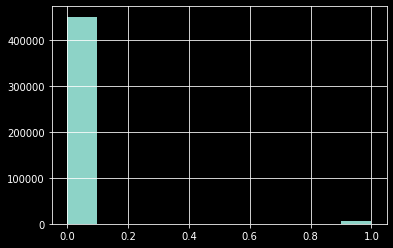

In [8]:
train['will_buy_on_return_visit'].hist()

### Create Container with Code and Train it with Vertex AI

In [19]:
TRAIN_IMAGE_URI = 'gcr.io/jchavezar-demo/visitor-purchase-train-ml:draft'
AIP_MODEL_DIR = 'gs://vtx-models/purchase/'
STAGING_DIR = 'gs://vtx-staging'
PRED_IMAGE_URI = 'us-central1-docker.pkg.dev/jchavezar-demo/predictions/pred_tf_pruchase:latest'

In [2]:
!rm -fr bqml_tf_keras
!mkdir bqml_tf_keras
!mkdir bqml_tf_keras/src
!cp -r src/* bqml_tf_keras/src/

In [3]:
%%writefile bqml_tf_keras/main.py
import os
import warnings
import argparse
from src import Estimator
warnings.filterwarnings('ignore')

TRAIN_START_DATE = "20160801"
TRAIN_END_DATE = "20170430"

def get_args():
    '''Parses args. Must include all hyperparameters you want to tune.'''
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--batch_size',
        default=32,
        type=int,
        help='batch size to build tf.data.Dataset')
    parser.add_argument(
        '--num_neurons',
        default=32,
        type=int,
        help='The number of neural neurons in the first layer'
        )
    parser.add_argument(
        '--learning_rate',
        default=0.001,
        type=float,
        help='number of units in the first hidden layer')
    parser.add_argument(
        '--epochs',
        default=10,
        type=int,
        help='The number of training iterations over the entire dataset'
        )
    parser.add_argument(
        '--label_column',
        default='will_buy_on_return_visit',
        type=str,
        help='The column to be predicted'
        )
    args = parser.parse_args()
    return args

def main():
    args = get_args()
    VertexTF = Estimator.VertexTF(
        project_id=os.environ['CLOUD_ML_PROJECT_ID'],
        epochs=args.epochs
        )
    train, val, test = VertexTF.query(start_date=TRAIN_START_DATE, end_date=TRAIN_END_DATE)
    train_ds, val_ds, test_ds = VertexTF.preprocessing(target_column=args.label_column)
    model = VertexTF.create_model(nn_input=args.num_neurons, lr=args.learning_rate)
    print(train_ds)
    history = model.fit(train_ds, epochs=args.epochs, validation_data=val_ds)

    hp_metric = history.history['val_accuracy'][-1]
    print(hp_metric)

    model.save(os.environ['AIP_MODEL_DIR'])

if __name__ == "__main__":
    main()

Writing bqml_tf_keras/main.py


In [4]:
%%writefile bqml_tf_keras/Dockerfile
FROM tensorflow/tensorflow

RUN pip install google-cloud-bigquery==2.34.4 \
    && pip install pandas \
    && pip install protobuf==3.19.4 \
    && pip install pyarrow \
    && pip install cloudml-hypertune

COPY . /

ENTRYPOINT ["python", "main.py"]

Writing bqml_tf_keras/Dockerfile


In [7]:
%%writefile bqml_tf_keras/Dockerfile
FROM us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-9:latest

COPY . /

ENTRYPOINT ["python", "main.py"]

Overwriting bqml_tf_keras/Dockerfile


### Cloud Build to Create and Push Image to Google Cloud Repository

In [ ]:
!gcloud builds submit -t $TRAIN_IMAGE_URI bqml_tf_keras/.

### Run the Custom Training Job on Vertex AI (CPU)

In [9]:
from google.cloud.aiplatform import CustomJob

worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": "n1-standard-4"
        },
        "replica_count": 1,
        "container_spec": {
            "image_uri": TRAIN_IMAGE_URI,

        }
    } 
]

job = CustomJob(
    display_name = 'visitor-purchases',
    worker_pool_specs = worker_pool_specs,
    staging_bucket = STAGING_DIR,
    base_output_dir = AIP_MODEL_DIR
)
job.run()

Creating CustomJob
CustomJob created. Resource name: projects/569083142710/locations/us-central1/customJobs/8717485362525503488
To use this CustomJob in another session:
custom_job = aiplatform.CustomJob.get('projects/569083142710/locations/us-central1/customJobs/8717485362525503488')
View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/8717485362525503488?project=569083142710
CustomJob projects/569083142710/locations/us-central1/customJobs/8717485362525503488 current state:
JobState.JOB_STATE_QUEUED
CustomJob projects/569083142710/locations/us-central1/customJobs/8717485362525503488 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/569083142710/locations/us-central1/customJobs/8717485362525503488 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/569083142710/locations/us-central1/customJobs/8717485362525503488 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/569083142710/locations/us-central1/customJobs/87174853

### Run the Custom Training Job on Vertex AI (GPU)

In [ ]:
from google.cloud.aiplatform import CustomJob

worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": "n1-standard-4",
            "accelerator_type": "NVIDIA_TESLA_V100",
            "accelerator_count": 1
        },
        "replica_count": 1,
        "container_spec": {
            "image_uri": TRAIN_IMAGE_URI,

        }
    } 
]

job = CustomJob(
    display_name = 'visitor-purchases',
    worker_pool_specs = worker_pool_specs,
    staging_bucket = STAGING_DIR,
    base_output_dir = AIP_MODEL_DIR
)
job.run()

### Creating Custom Prediction Container Vertex AI

In [10]:
!rm -fr bqml_tf_keras/app
!mkdir bqml_tf_keras/app

In [85]:
%%writefile bqml_tf_keras/app/main.py

from fastapi import Request, FastAPI
import json
import os
import sys
import tensorflow as tf

app = FastAPI()

x=os.environ['AIP_STORAGE_URI']
print(f'[INFO] ------ {x}', file=sys.stderr)

# Loading Model File

model = tf.keras.models.load_model(os.environ['AIP_STORAGE_URI'])

# Webserver methods

@app.get('/')
def get_root():
    return {'message': 'Welcome to Breast Cancer Prediction'}
@app.get('/health_check')
def health():
    return 200
if os.environ.get('AIP_PREDICT_ROUTE') is not None:
    method = os.environ['AIP_PREDICT_ROUTE']
else:
    method = '/predict'
print(method)
@app.post(method)
async def predict(request: Request):
    print("----------------- PREDICTING -----------------")
    body = await request.json()
    instances = body["instances"]
    columns = ["bounces", "channelGrouping", "country", "deviceCategory", "latest_ecommerce_progress", "medium", "pageviews", "source", "time_on_site"]
    print(instances, file=sys.stderr)
    zip_iterator = zip(columns, instances)
    print(zip_iterator, file=sys.stderr)
    sample = dict(zip_iterator)
    print(sample, file=sys.stderr)
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
    predictions = model.predict(input_dict)
    prob = tf.nn.sigmoid(predictions[0])
    outputs = [round(prob.numpy()[0])]
    print(f'[INFO] ------ {outputs}, {type(outputs)}', file=sys.stderr)
    response = outputs
    print("----------------- OUTPUTS -----------------")
    return {"predictions": response}

Overwriting bqml_tf_keras/app/main.py


In [86]:
%%writefile bqml_tf_keras/app/Dockerfile

FROM tiangolo/uvicorn-gunicorn-fastapi:python3.7

COPY . /app
WORKDIR /app
RUN pip install tensorflow
CMD ["uvicorn", "main:app", "--host", "0.0.0.0", "--port", "8080"]

EXPOSE 8080

Overwriting bqml_tf_keras/app/Dockerfile


In [ ]:
!!gcloud builds submit -t $PRED_IMAGE_URI bqml_tf_keras/app/.

In [89]:
## Upload Model
from google.cloud import aiplatform as aip

model = aip.Model.upload(
    display_name="purchases_oct_18",
    artifact_uri=AIP_MODEL_DIR+'/model',
    serving_container_image_uri=PRED_IMAGE_URI,
    serving_container_predict_route='/predict',
    serving_container_health_route='/health_check',
    sync=False,
)

model.wait()

Creating Model
Create Model backing LRO: projects/569083142710/locations/us-central1/models/3385541437457170432/operations/2860909807861235712
Model created. Resource name: projects/569083142710/locations/us-central1/models/283792747222007808@1
To use this Model in another session:
model = aiplatform.Model('projects/569083142710/locations/us-central1/models/283792747222007808@1')
Model created. Resource name: projects/569083142710/locations/us-central1/models/3385541437457170432@1
To use this Model in another session:
model = aiplatform.Model('projects/569083142710/locations/us-central1/models/3385541437457170432@1')


## Create Batch File to Predict

In [90]:
test.iloc[:10,1:].to_csv('test.csv', index=False, header=False)

In [91]:
!gsutil cp test.csv gs://vtx-datasets/test/test.csv

Copying file://test.csv [Content-Type=text/csv]...
/ [1 files][  582.0 B/  582.0 B]                                                
Operation completed over 1 objects/582.0 B.                                      


## Create a Batch Prediction Job

In [ ]:
MIN_NODES = 1
MAX_NODES = 1

batch_predict_job = model.batch_predict(
    job_display_name="purchases_oct_18",
    gcs_source='gs://vtx-datasets/test/test.csv',
    gcs_destination_prefix="gs://vtx-batch-results",
    instances_format="csv",
    predictions_format="jsonl",
    machine_type='n1-standard-4',
    starting_replica_count=MIN_NODES,
    max_replica_count=MAX_NODES,
    generate_explanation=True,
    sync=False,
)

print(batch_predict_job)

## Appendix

In [10]:
## Loading Model Locally

import tensorflow as tf
model = tf.keras.models.load_model("gs://vtx-models/purchase/model")

In [11]:
test

,will_buy_on_return_visit,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country
207583,0,0,1,0,1,google,organic,Organic Search,desktop,Hong Kong
178945,0,0,1,0,1,youtube.com,referral,Social,desktop,Hong Kong
134169,0,0,1,0,1,google,organic,Organic Search,mobile,Canada
505259,0,2,0,930,13,google,organic,Organic Search,desktop,United States
382,0,0,0,773,9,google,organic,Organic Search,mobile,United Kingdom
...,...,...,...,...,...,...,...,...,...,...
62374,0,0,1,0,1,google,organic,Organic Search,mobile,India
479536,0,0,0,56,2,youtube.com,referral,Social,desktop,Vietnam
117280,0,0,1,0,1,youtube.com,referral,Social,desktop,United States
123643,0,0,0,9,2,(direct),(none),Direct,mobile,Canada


In [12]:
prediction = model.predict(test_ds)[0]
prob = tf.nn.sigmoid(prediction)
[round(prob.numpy()[0])]

/home/jesusarguelles/miniconda3/envs/gcp/lib/python3.7/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['will_buy_on_return_visit'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1791/1791 [==============================] - 3s 2ms/step


[0]

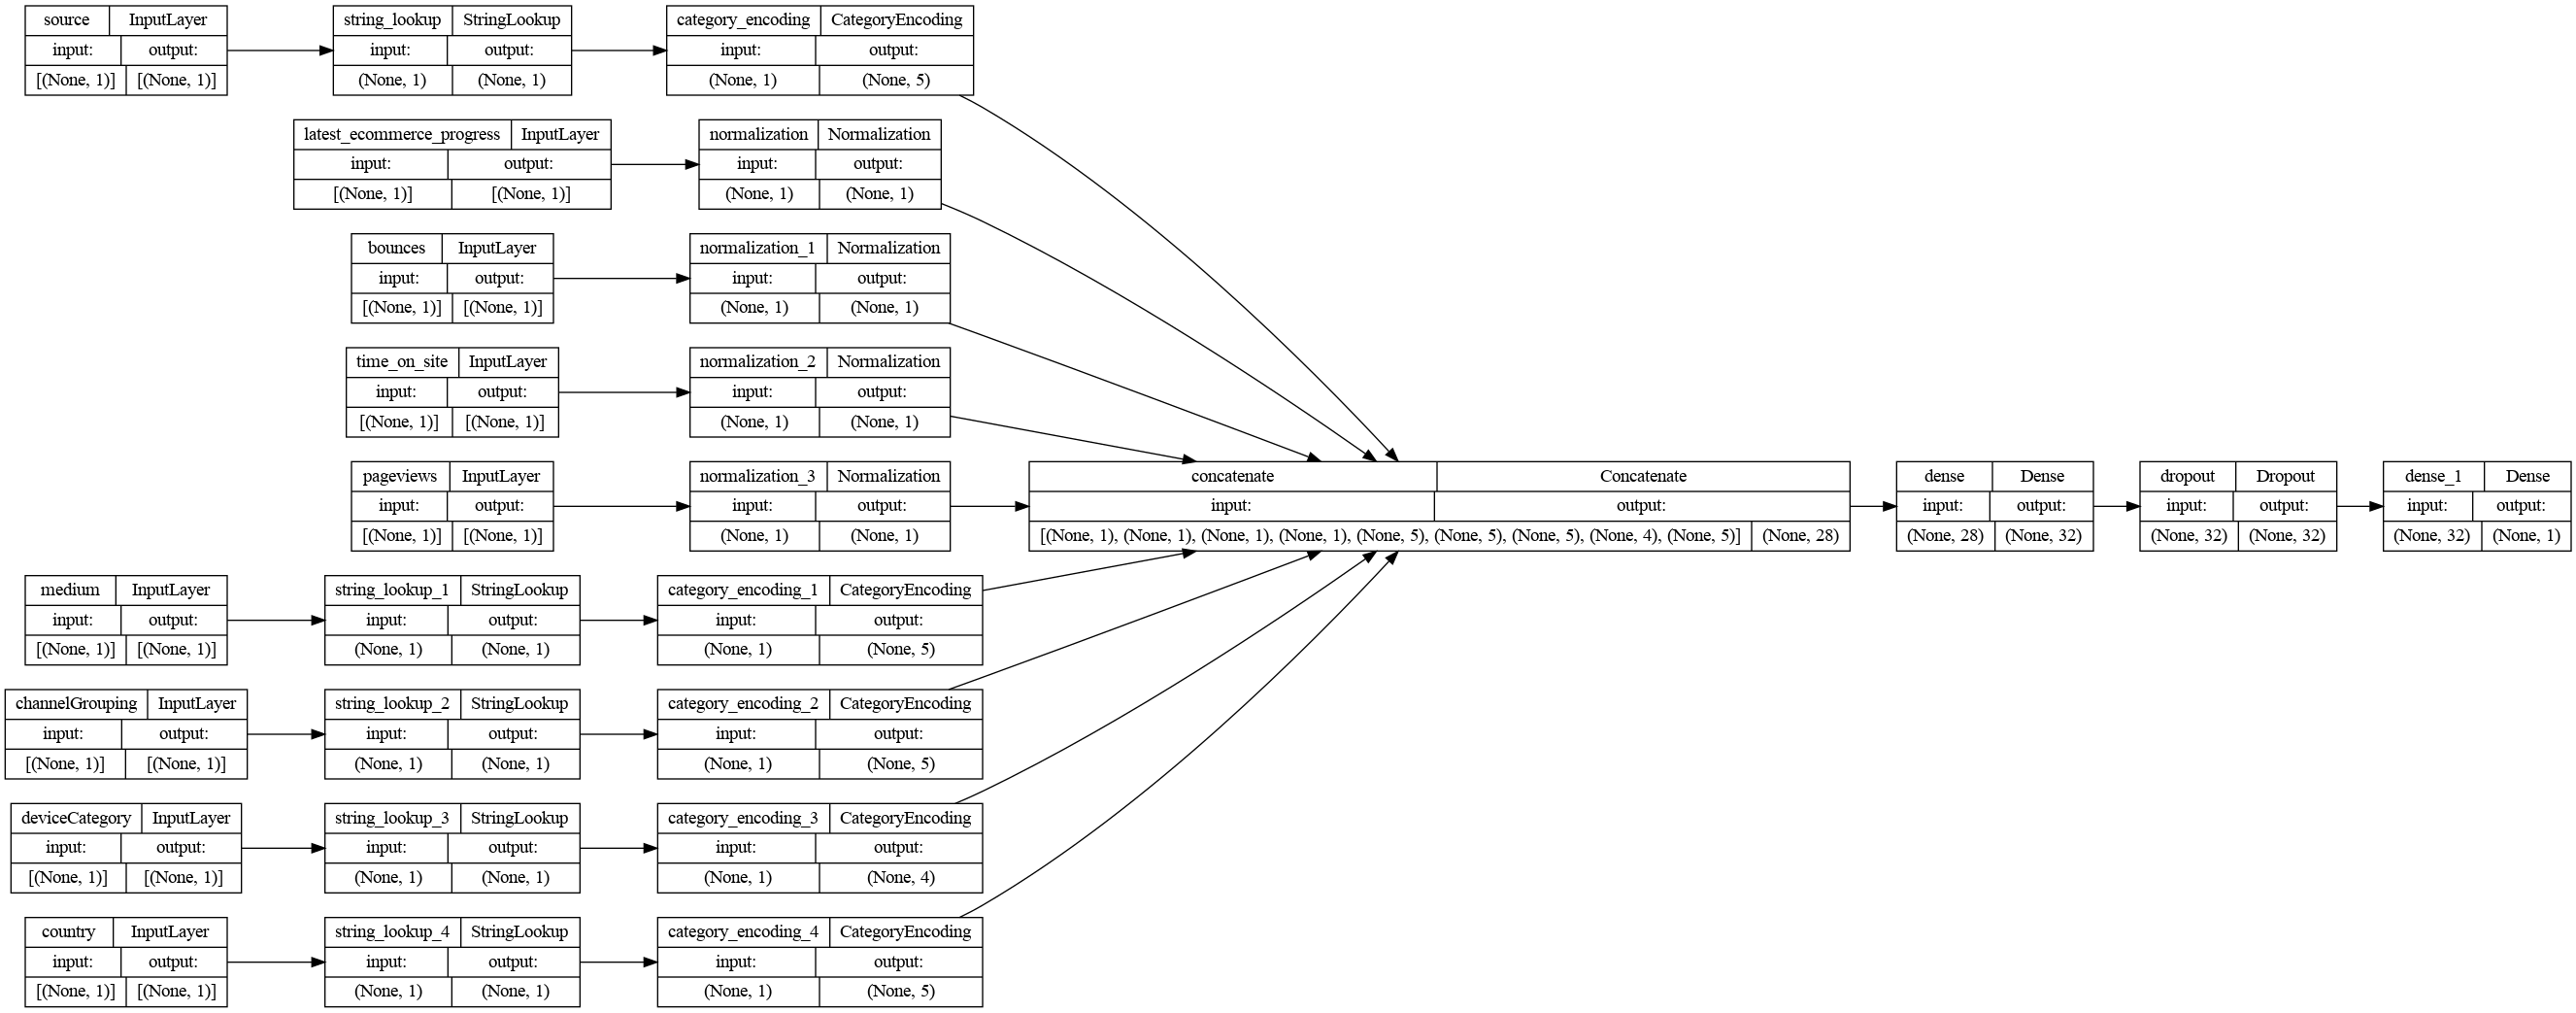

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")